In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from astroML.datasets import fetch_sdss_sspp
#from astroML.utils.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

/Users/dsluse/miniconda3/envs/py_SPAT0086_py312/lib/python3.12/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## KDE applied to 2D histogram

In [2]:
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14), 
                    np.random.normal(1, 0.3, size=7)])

In [3]:
# data
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75], size=(500,2)), 
                    np.random.normal([1,1],[1,1], size=(1000,2))]) 

kde = KernelDensity(kernel='gaussian', bandwidth=0.4)
kde.fit(X) #fit the model to the data

# let's evaluate the result of the fit on a grid of values "(u_i, v_j)"
u = v = np.linspace(-4,5,80)
U, V = np.meshgrid(u, v)

# Now we need to evaluate the density (i.e. likelihood of the pdf) on that grid ... 
# and deal with the sklearn format => we need first to build a matrix with all 
# the coordinates along 2 columns 
# each row is "a sample" of the feature matrix 
Xgrid = np.zeros(shape=(len(u) * len(v), 2)) 
for i in range(Xgrid.shape[0]):
    Xgrid[i, 0] = np.ravel(U)[i]    # axis x
    Xgrid[i, 1] = np.ravel(V)[i]   # axis y

[0.01       0.04413793 0.07827586 0.11241379 0.14655172 0.18068966
 0.21482759 0.24896552 0.28310345 0.31724138 0.35137931 0.38551724
 0.41965517 0.4537931  0.48793103 0.52206897 0.5562069  0.59034483
 0.62448276 0.65862069 0.69275862 0.72689655 0.76103448 0.79517241
 0.82931034 0.86344828 0.89758621 0.93172414 0.96586207 1.        ]
0.3513793103448276


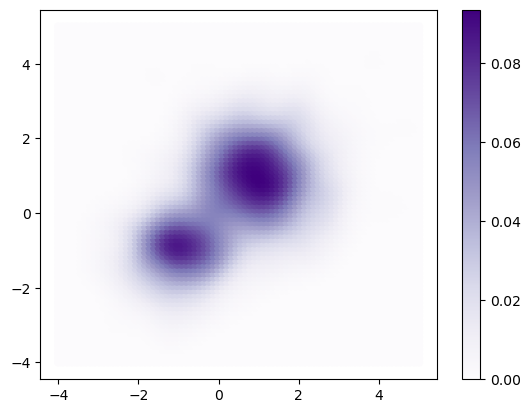

In [4]:
#### I pasted the gridsearch from here...
bwrange = np.linspace(0.01,1.0, 30)
print(bwrange)
K = 15 
#grid = GridSearchCV(KernelDensity(kernel='epanechnikov'), {'bandwidth': bwrange}, cv= K)
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
grid.fit(X)  # This is the only thing we changed compared to the 1D case ! 
h_opt = grid.best_params_['bandwidth']

print(h_opt)
### ... to here

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt) # Changed here.
#kde = KernelDensity(kernel='tophat', bandwidth=h_opt) # Changed here.
kde.fit(X) 

u = v = np.linspace(-4,5,80)
#Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T

Xgrid = np.zeros(shape=(len(u) * len(v), 2)) 
for i in range(Xgrid.shape[0]):
    Xgrid[i, 0] = np.ravel(U)[i]    # axis x
    Xgrid[i, 1] = np.ravel(V)[i]   # axis y


dens = np.exp(kde.score_samples(Xgrid))

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()


Text(0.5, 0, 'Band width')

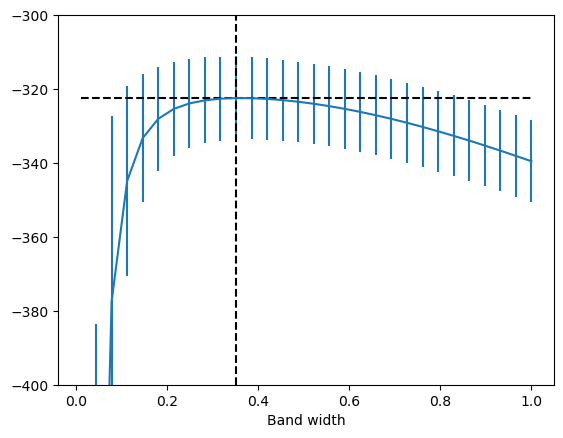

In [5]:
# can we visualise the results of the cv for each "h" considered 
mu_cv, std_cv = grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score']
plt.errorbar(bwrange, mu_cv, yerr=std_cv)
plt.ylim(-400, -300)
plt.vlines(h_opt, -400, -300, color='black', ls='--')
plt.hlines(mu_cv.max(), bwrange[0], bwrange[-1], color='black', ls='--')
plt.xlabel('Band width')

## Applying GMM to iris data

The idea is to ignore existing classes but see if we are able to recover them using GMM 

In [6]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target # this contains the solution (each index is a different species - we won't provide 
N, K = X.shape
print(N, K)

150 4


In [7]:
# before applying the MM, let's rescale the data 
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled_array = scaler.transform(X)

In [8]:
from sklearn.mixture import GaussianMixture

Ncomp = 3
gmm = GaussianMixture(n_components=Ncomp, covariance_type='full')
gmm.fit(X_scaled_array)

# predict the cluster for each data point
y_lab_gmm = gmm.predict(X_scaled_array)
y_lab_gmm


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
# Comparison with true labels 
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

There is a need to remap the label names because e.g. label 1 predicted by the GMM is NOT the same as label 1 for the "true" label. 

In [10]:
# For comparing to the truth, we can cheat and use the real targets to re-label the data 
from scipy.stats import mode
true_label = y.copy()
y_lab_gmm_new = y_lab_gmm.copy()
for i in range(3):  # this is the names of the true labels
    mask = (y_lab_gmm == i)
    print(i, mode(y[mask], keepdims=True))  # use of mode in the "predicted" label allow us to know what is the most represented label
    y_lab_gmm_new[mask] = mode(y[mask], keepdims=True)[0] 

0 ModeResult(mode=array([1]), count=array([45]))
1 ModeResult(mode=array([2]), count=array([50]))
2 ModeResult(mode=array([0]), count=array([50]))


In [11]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y, y_lab_gmm_new)
acc_score 

0.9666666666666667

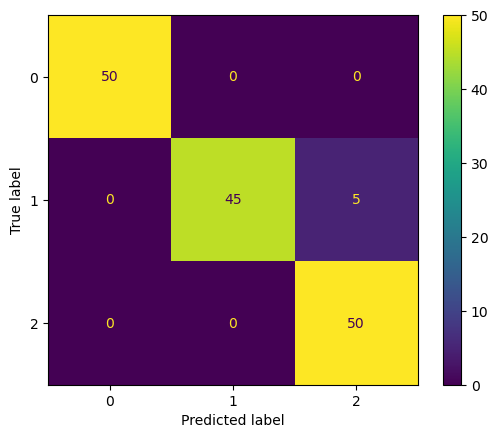

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
c_mat = confusion_matrix(y, y_lab_gmm_new)
c_mat_display = ConfusionMatrixDisplay(c_mat).plot()

Waw, that's pretty efficient. 

What if we did not know the number of classes? Would the BIC tell us that we have too many components? 

In [13]:
aic, bic = [], [] 
for i, Ncomp in enumerate(range(2, 12)): 
    gmm = GaussianMixture(n_components=Ncomp, covariance_type='full')
    gmm.fit(X_scaled_array)
    # predict the cluster for each data point
    y_lab_gmm = gmm.predict(X_scaled_array)
    bic.append(gmm.bic(X_scaled_array))
    aic.append(gmm.aic(X_scaled_array))

(np.int64(8), np.int64(0))

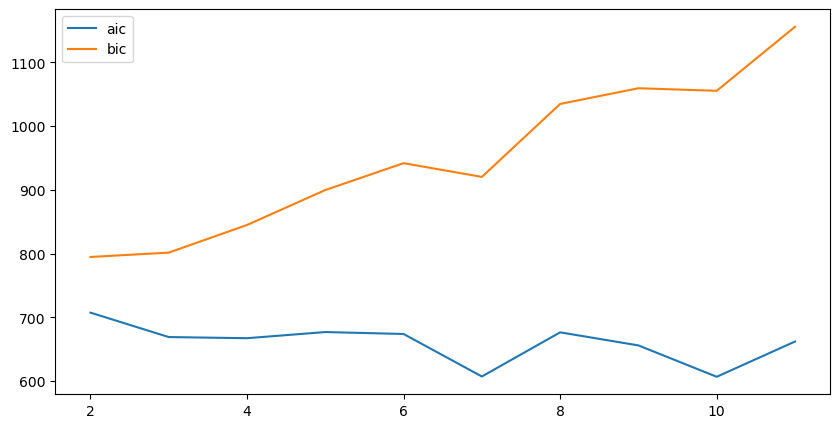

In [14]:
f, ax = plt.subplots(ncols=1, figsize=(10,5))
ax.plot(np.arange(2,12,1), aic, label='aic')
ax.plot(np.arange(2,12,1), bic, label='bic')
ax.legend()
np.array(aic).argmin(), np.array(bic).argmin()

=> no, the BIC and AIC are not finding the right number of classes ... 

## Clustering on iris data

In [16]:
# from sklearn import datasets
#from sklearn import preprocessing
iris = datasets.load_iris()
X = iris.data
y = iris.target # this contains the solution (each index is a different species - we won't provide 
N, K = X.shape
print(N, K)

scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled_array = scaler.transform(X)

150 4


In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
km_fit = kmeans.fit(X_scaled_array)
# let's do the prediction for the same data set 
km_predict = kmeans.predict(X_scaled_array)
kmeans_raw_centers = kmeans.cluster_centers_
kmeans_raw_centers.shape

(3, 4)

Cluster centers is the center of the clusters in D-Dimensions, where D is the number of features. 
In practice, this is an array of 4 columns (the 4 features) and 3 raws (for the 3 classes). 
Each row provides the "mean values" of the features for a given class.  

In [18]:
# For comparing to the truth, we can cheat and use the real targets to re-label the data 
from scipy.stats import mode
from sklearn.metrics import accuracy_score
true_label = y.copy()
km_predict_new = km_predict.copy()
for i in range(3):
    mask = (km_predict == i)
    km_predict_new[mask] = mode(y[mask], keepdims=True)[0] 
acc_score = accuracy_score(y, km_predict_new)
acc_score

0.8333333333333334

This is effectively less good than the GMM ... probably because kmeans assumes circular distribution. One could see if kmeans efficiency) improves in presence of PCA (and even rescaled PCA). 

In [19]:
# what about the mean shift clustering? 
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X_scaled_array)

In [20]:
print(bandwidth)

1.6024771502953163


In [21]:
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X_scaled_array))

MeanShift(bandwidth=np.float64(1.6024771502953163), bin_seeding=True,
          cluster_all=False)

In [22]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

[-1  0  1]
1.6024771502953163
number of estimated clusters : 2


=> Only 2 clusters are found. This could partly be expected from our original analysis of the data where we observed intricated properties of w of the 3 iris types. 

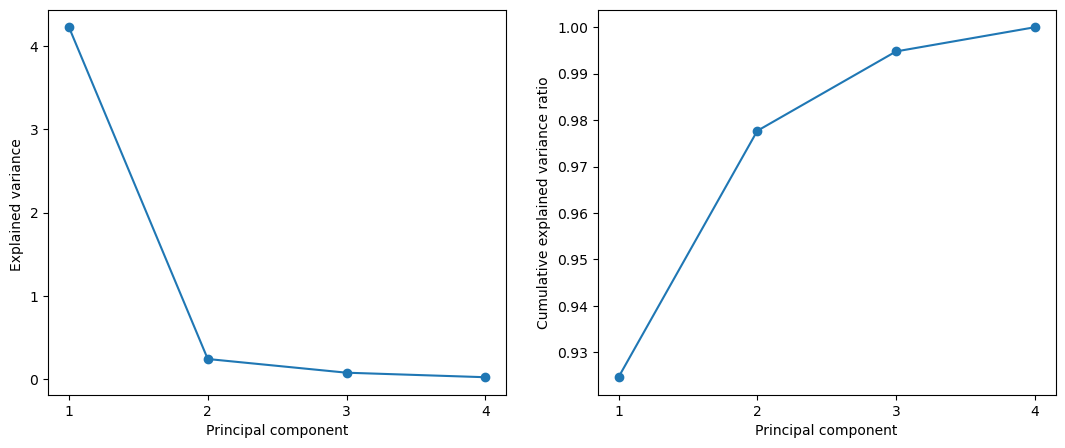

In [23]:
# trying to apply PCA first 
from sklearn.decomposition import PCA
pca = PCA() # no argument, means all pcs are calculated
pca.fit(X)

pcs_s = pca.components_
ev_s = pca.explained_variance_
evr_s = pca.explained_variance_ratio_

f, ax = plt.subplots(ncols=2, figsize=(13,5))
ax[0].plot(np.arange(K)+1, ev_s)
ax[0].scatter(np.arange(K)+1, ev_s)
ax[0].set_xlabel("Principal component")
ax[0].set_ylabel("Explained variance ")
ax[0].set_xticks(np.arange(K)+1)

ax[1].plot(np.arange(K)+1, evr_s.cumsum())
ax[1].scatter(np.arange(K)+1, evr_s.cumsum())
ax[1].set_xlabel("Principal component")
ax[1].set_ylabel("Cumulative explained variance ratio")
ax[1].set_xticks(np.arange(K)+1)


In [24]:
# let's use 3 components PCA (we reduce dimensionality from 4 to 3 ... 
pca = PCA(n_components=3) # here we now specify we want 3 components
pca.fit(X)
Xt = pca.transform(X)

In [25]:
#scaler = preprocessing.StandardScaler()
#scaler.fit(Xt)
#Xt_scaled_array = scaler.transform(Xt)
Xt_scaled_array = Xt.copy()

In [26]:
kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
km_fit = kmeans.fit(Xt_scaled_array)
# let's do the prediction for the same data set 
km_predict = kmeans.predict(Xt_scaled_array)
kmeans_raw_centers = kmeans.cluster_centers_
kmeans_raw_centers.shape

(3, 3)

In [27]:
true_label = y.copy()
km_predict_new = km_predict.copy()
for i in range(3):
    mask = (km_predict == i)
    km_predict_new[mask] = mode(y[mask], keepdims=True)[0] 
acc_score = accuracy_score(y, km_predict_new)
acc_score

0.8933333333333333

THis is better than without PCA. 

### An attempt using the mean shift 

As we will see, this methods is unsuccess ful. 

In [30]:
# now, let's apply meanshift 

bandwidth = estimate_bandwidth(Xt_scaled_array)
print(bandwidth)
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(Xt_scaled_array))


1.1817494920287606


MeanShift(bandwidth=np.float64(1.1817494920287606), bin_seeding=True,
          cluster_all=False)

In [31]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

[-1  0  1  2  3  4]
1.1817494920287606
number of estimated clusters : 5


=> the meanshift does not work welll ... with a not rescaled PCA we have 5 clusters and only 1 with a rescaled PCA ... 

## Clustering on Handwritten digits 

There is one popular and fun data set available in sklearn, it is the one from the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). This dataset contains a set of images with handwritten digts. It is probably also one of the most widely used and best studied datasets in the whole of machine learning. 

To load the data set you may use the function 'sklearn.datasets.load_digits()'. Take a few minutes to read the `DESCR`-iption of this data set. 

This dataset comes with labels, but for this exercise, we will ignore the latter and see if we are able to identify the existence of 10 classes using unsupervised learning methods. Then we will compare the results to the truth to evaluate the performances of our algorithm. This can be seen as a sort of benchmarking.  

- Load the data set 
- Visualise a subsample of the data set (e.g. 10x10 images containing 100 different digits).
- Apply the K-mean to this data set to identify 10 clusters corresponding to the 10 digits.
- Visually inspect the 10 centers of the k-means and maps the "k-means labels" to the "true label". E.g. if the first cluster (i.e. cluster \#0) correspond to digit 3 you will have to relabel the predictions of k-means to 3, and so-on for the 10 different clusters.
- Calculate the accuracy score of the k-mean
- Calculate and visualise the confusion matrix, comparing the predicted labels to the truth. TIP: Search for `ConfusionMatrixDisplay`, `confusion_matrix` in `sklearn.metrics`

BONUS: If you have time, try to improve the accuracy of the identification by first using a dimensionality reduction method prior to using the K-means. The t-SNE gives pretty amazing results but you may need to "cheat" using the known labels to relabel the prediction of the tSNE-kmean. You may relabel the output of tSNE by relabeling each k-mean label using the maximum number of occurence of the true-label for each k-mean label. 

In [32]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.images.shape)
print(digits.data.shape)
print(digits.keys())

(1797, 8, 8)
(1797, 64)
dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [34]:
# More information about this dataset
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

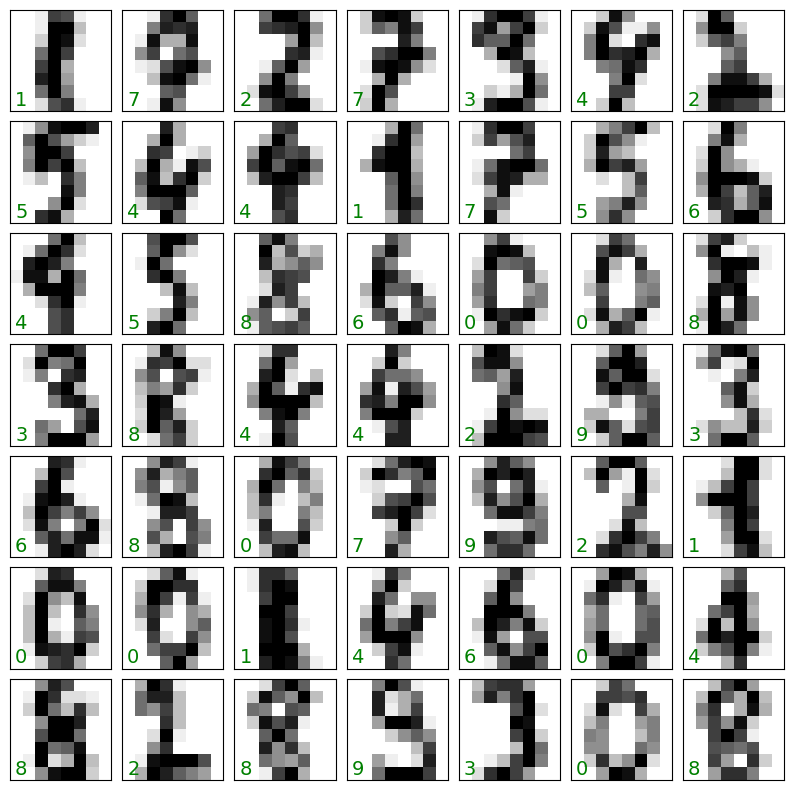

In [35]:
fig, axes = plt.subplots(7,7, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

np.random.seed(42)
mychoices = np.random.choice(digits.images.shape[0],100)

for i, ax in enumerate(axes.flat):
    ax.imshow((digits.images[mychoices[i]]), 
              cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[mychoices[i]]),transform=ax.transAxes, color='green', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    

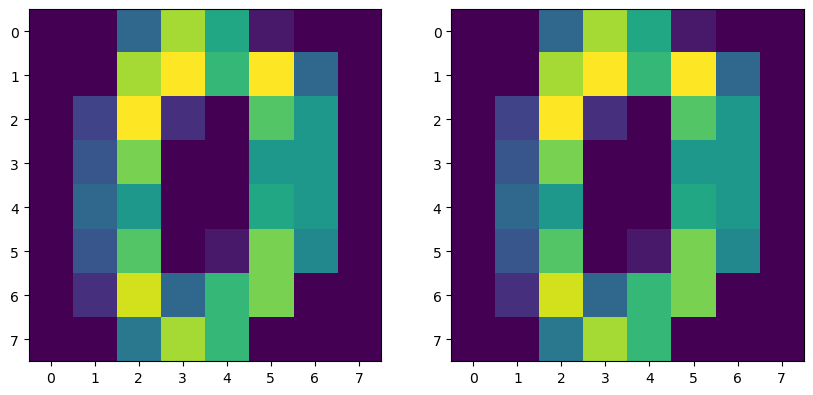

In [36]:
# Let's check that we can manipulate data / reshape arrays properly. 
f, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(digits.data[0, :].reshape(8,8))
ax[1].imshow(digits.images[0, :, :])

We see that for each pixel of the image, the values range between 0 and 16, which corresponds to the intensity of the pixel. 

In [37]:
# Let's apply kmeans on the 64 "features" corresponding to the intensity
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
clusters = kmeans.fit(digits.data)
# let's do the prediction for the same data set 
clusters_predict = kmeans.predict(digits.data)
# alternative 
# clusters_predict = kmeans.fit_predict(digits.data)
kmeans_raw_centers = kmeans.cluster_centers_
kmeans_raw_centers.shape

(10, 64)

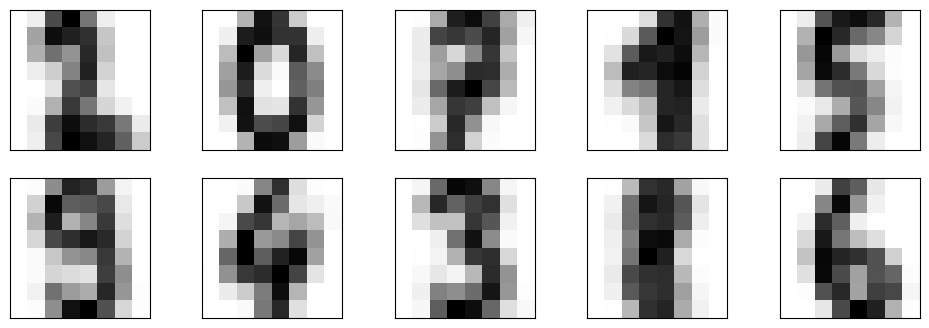

In [38]:
# let's see what the cluster centers look like
# for this we need to reashape the 64 features 
centers = kmeans.cluster_centers_.reshape((10, 8, 8))
f, ax = plt.subplots(2,5, figsize=(12, 4))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

So, the main problem occurs with idenfying the 8 which is apparently often confused with the 1... 

In [39]:
# now, we can generate labels for these 10 clusters manually 
my_labels_names = np.array([2, 0, 7, 1, 5, 9, 4, 3, 8, 6])
# let's associate the labels to the data points 
label_predict = kmeans.predict(digits.data)
# rename the labels 
label_predict_renamed = np.zeros_like(label_predict)
for i in range(10): 
    mask = (label_predict == i)
    label_predict_renamed[mask] = my_labels_names[i]

In [40]:
# Now we can calculate an accuracy score 
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, label_predict_renamed)

0.7935447968836951

=> With just a simple k-means algorithm, we discovered the correct grouping for 80% of
the input digits!

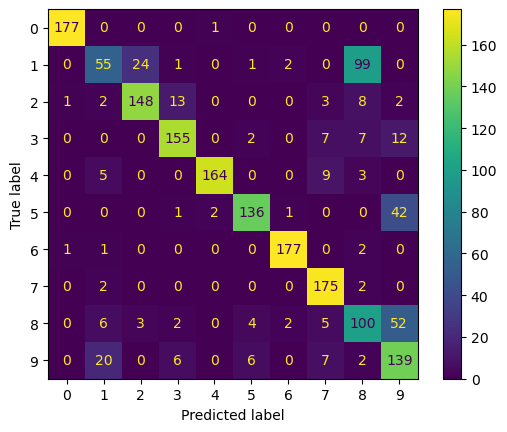

In [41]:
# Display the confusion matrix nicely 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
c_mat = confusion_matrix(digits.target, label_predict_renamed)
c_mat_display = ConfusionMatrixDisplay(c_mat).plot()